In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from load_ixi import load_data
data_path = '/srv/Data/playground_data/ixi_data/ixi'
h5_path = '/srv/Data/playground_data/ixi_data/h5_ixi'

In [2]:
cls = load_data(data_path,h5_path)
loader = torch.utils.data.DataLoader(cls,batch_size = 1,\
                                              shuffle = True ,num_workers= 1)
obj = iter(loader)
image,label = next(obj)

/home/arunima/.local/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)


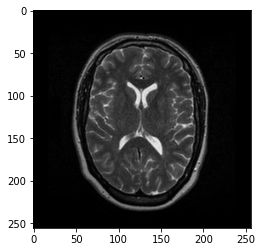

In [3]:
img = image[0,0,:,:].numpy()
plt.imshow(img,cmap = 'gray')

In [4]:
def normalize(image):
    return (image - image.min())/(image.max()-image.min())


In [5]:
img = normalize(img)
lenx,leny=np.shape(img)
img_rot_1=np.zeros_like(img)
theta=np.random.uniform(-np.pi/90,np.pi/90)  
# theta = 0.001
img_rot = img

for i in range(lenx):
    for j in range(leny):
        
        i,j=i-lenx//2,j-leny//2 #USUALLY ORIGIN IS AT UPPER LEFT. HERE WE ARE SHIFTING IT TO THE MIDDLE TO USE CENTER AS PIVOT
        
        xt=i*np.cos(theta)- j*np.sin(theta) + lenx//2
        yt=j*np.cos(theta)+ i*np.sin(theta) + leny//2
        xf,yf=int(np.floor(xt)),int(np.floor(yt))
        a=xt-xf
        b=yt-yf
        i,j=i+lenx//2,j+leny//2 #REALIGNING THE INDEX VALUES
        
        if xf>=0 and xf<lenx-1 and yf>=0 and yf<leny-1:
            
            img_rot_1[i,j]=(1-a)*(1-b)*img_rot[xf,yf]+ (1-a)*b*img_rot[xf,yf+1]+ a*(1-b)*img_rot[xf+1,yf]+a*b*img_rot[xf+1,yf+1]#Bilinear-Interpolation
        else:
            img_rot_1[i,j]=0
        

0.49722345948439256

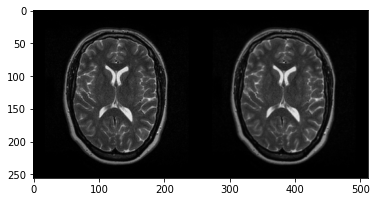

In [23]:
plt.imshow(np.concatenate((img,img_rot_1),axis=1),cmap = 'gray')
theta*180/np.pi

In [7]:
def create_mask(inp,downsampling_rate):
    xlen = inp.shape[-2]
    ylen = inp.shape[-1]
    
    mask = np.zeros((xlen,ylen))
    nacs = round(ylen/downsampling_rate**2)
    acs = round((ylen - nacs) / 2)
    
    acs1 = nacs + acs
    mask[acs:acs1,:] =1
    
    noSamples = int(ylen/downsampling_rate)
    r = np.floor(np.random.normal(ylen / 2, 70, noSamples))
    r = np.clip(r.astype(int), 0, ylen - 1)
    mask[r.tolist(), :] = 1
    return mask

In [8]:
x = create_mask(img,3)
# x[:,0]

In [9]:
ksp = np.fft.fftshift(np.fft.fft2(img_rot_1))
degraded = ksp*x
recon = np.abs(np.fft.ifft2(np.fft.ifftshift(degraded)))
recon = normalize(recon)

In [10]:
import math
def psnr(original, contrast):
    mse = np.mean((original - contrast) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1
    PSNR = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
    return PSNR

In [11]:
img.max(),img.min(),recon.max(),recon.min()

(1.0, 0.0, 1.0, 0.0)

In [12]:
p = psnr(img,recon)
from skimage.metrics import structural_similarity as ssim
s = ssim(img,recon,data_range=img.max()-img.min())

Text(0.5, 1.0, 'PSNR: 27.357890952590616 , SSIM: 0.7713308565256558')

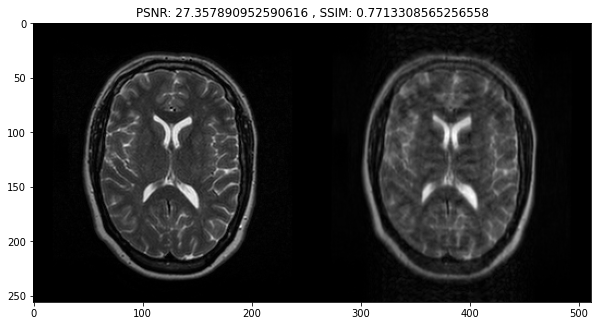

In [13]:
y = np.concatenate((img,recon),axis=1)
plt.figure(figsize = (10,10))
plt.imshow(y,cmap='gray')
plt.title(f"PSNR: {p} , SSIM: {s}")

In [14]:
# plt.imshow(img_rot_1,cmap = 'gray')

In [15]:
# ksp = np.abs(np.fft.fftshift(np.fft.fft2(img_rot_1)))
# plt.imshow(ksp,cmap= 'gray')
# deltax = np.random.uniform(-0.5,0.5)  
# deltay = np.random.uniform(-1,1)
# # for xloc in range(0,256):
# #     for yloc in range(0,256):
# #         kx,ky = ksp[]

In [16]:
# import torchio
# theta=np.random.uniform(0,np.pi/90)  
# op = torchio.transforms.RandomMotion(degrees=np.pi/90,translation=(-7,7))

In [17]:

# import math
# from skimage.metrics import structural_similarity as ssim
# def psnr(original, contrast):
#     mse = np.mean((original - contrast) ** 2)
#     if mse == 0:
#         return 100
#     PIXEL_MAX = 1
#     PSNR = 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
#     return PSNR

In [18]:
# im = op(image)
# degraded = normalize(im.squeeze().numpy())
# normal = normalize(image.squeeze().numpy())
# plt.imshow(degraded,cmap = "gray")

In [19]:
# p =psnr(normal,degraded)
# s = ssim(normal,degraded,data_range=degraded.max()-degraded.min())
# p,s

In [20]:
# y = np.concatenate((normal,degraded),axis=1)
# plt.figure(figsize=(10,10))
# plt.imshow(y,cmap = 'gray')
# plt.title(f"PSNR: {p}, SSIM {s}")

In [21]:
# r = np.floor(np.random.normal(256 / 2, 50, 85))
# x = np.clip(r.astype(int), 0, 256 - 1)
